### **컨브넷 훈련하기**

#### **01. 데이터 내려받기**

* 참고 : '403 Forbidden'에러 발생하는 경우, 연관된 규칙에 동의해야 함 
         로그인 -> https://www.kaggle.com/c/dogs-vs-cats  -> rules 페이지로 이동 -> I UbderStand and Accept (약관동의) 

In [9]:
# kaggle.json 파일을 업로드하세요.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"lucyjun","key":"47f3cd85ea8a8afeada253edc86bbd8c"}'}

In [10]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [11]:
!kaggle competitions download -c dogs-vs-cats

100% 809M/812M [00:35<00:00, 25.1MB/s]
100% 812M/812M [00:35<00:00, 23.8MB/s]


In [12]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

#### **02. 이미지를 훈련, 검증, 테스트 디렉토리로 복사하기**

*디덱터터리 구조 *

cat_vs_dogs_small/

>..**train** /

>.... cat/  ---- 1,000개의 고양이 이미지 데이터 
    
>.... dog/  ---- 1,000개의 강아지 이미지 데이터

>..**validation** /
    
>.... cat/  ---- 500개의 고양이 이미지 데이터 
    
>.... dog/  ---- 500개의 강아지 이미지 데이터

>..**test** /
    
>.... cat/  ---- 1,000개의 고양이 이미지 데이터 
    
>.... dog/  ---- 1,000개의 강아지 이미지 데이터



In [13]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

#### **03. 모델 만들기**


*   강아지 vs. 고양이 분류를 위한 소규모 컨브넷 만들기


In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))

x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

#### **04. 모델 훈련 설정하기** 



*   loss="binary_crossentropy" :  분류 손실함수 중 하나로 이진 분류 모델에 사용



In [21]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### **데이터 전처리** 

1. 사진 파일 읽기
2. JPEG 파일을 RGB 픽셀 값으로 디코딩
3. 부동 소수점 타입의 텐서로 변환 
4. 동일 크기의 이미지로 변경 ( 180 * 180 )
5. 배치로 묶기 ( 하나의 배치에 32개의 이미지로 구성 )

#### **01. image_dataset_from_directory를 사용하여 이미지 읽기**

In [22]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


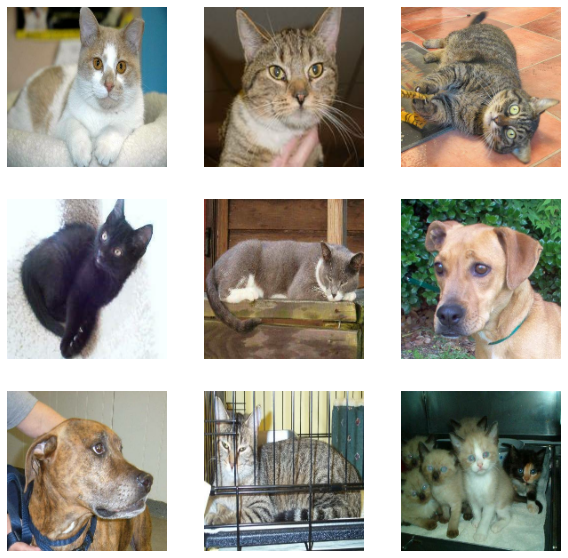

In [23]:
# train_dataset은 batch_size=32로 해서 만들었기 때문에, 
# 각 배치별로 크기(shape)가 (32, 180, 180, 3)인데요. 
# 그래서 거기서 하나를 뽑으면 (32, 180, 180, 3)가 나와요. 

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):   # 배치 1개(=사진 32장)가 뽑혀 나와요
    for i in range(9):
        #augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

#### **02. Dataset이 반환하는 데이터와 레이블 크기 확인하기**

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("데이터 배치 크기:", data_batch.shape)
    print("레이블 배치 크기:", labels_batch.shape)
    # break

#### **03. Dataset을 사용해 모델 훈련하기**

In [25]:
# epochs이 끝날 때마다 모델을 저장
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")  #val_loss 값이 이전보다 더 낮을 때만 콜백
]
history = model.fit(
    train_dataset,
    epochs=3,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/3
63/63 [==============================] - 16s 83ms/step - loss: 0.7328 - accuracy: 0.5235 - val_loss: 0.6747 - val_accuracy: 0.5730
Epoch 2/3
63/63 [==============================] - 5s 72ms/step - loss: 0.7110 - accuracy: 0.5630 - val_loss: 0.6853 - val_accuracy: 0.6000
Epoch 3/3
63/63 [==============================] - 5s 72ms/step - loss: 0.6472 - accuracy: 0.6385 - val_loss: 0.6391 - val_accuracy: 0.6270


#### **04. 훈련 정확도와 손실 그래프 그리기**

1) 과대적합(overfitting)


*   학습할 때 학습 데이터셋에 지나치게 최적화하여 발생하는 문제
*    학습 데이터셋에서는 모델 성능이 높게 나타나지만 정작 새로운 데이터가 주어졌을 때 정확한 예측/분류를 수행하지 못함


2) 과소적합(underfitting)
* 모델이 충분히 복잡하지 않아(최적화가 제대로 수행되지 않아) 학습 데이터의 구조/패턴을 정확히 반영하지 못하는 문제


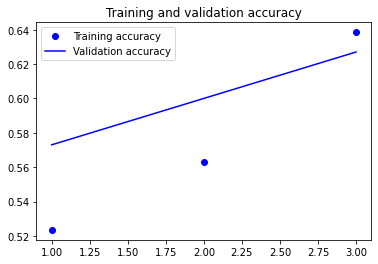

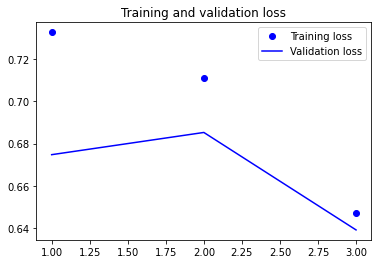

In [26]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# Training and validation accuracy 그래프 그리기
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

# Training and validation loss 그래프 그리기
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### **05. 테스트 세트에서 모델 평가하기**

In [27]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 3s 38ms/step - loss: 0.6458 - accuracy: 0.6295
테스트 정확도: 0.629


### **데이터 증식 사용하기**

#### **1. 이미지 변형하기** 

**cifar10 데이터 가져오기**
*   CIFAR-10 dataset은 32x32픽셀의 60000개 컬러이미지가 포함
*   이미지는 10개의 클래스로 라벨링 되어 있음
*   참고: https://www.cs.toronto.edu/~kriz/cifar.html

In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

In [29]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


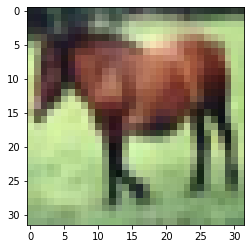

In [30]:
plt.imshow(train_images[7])

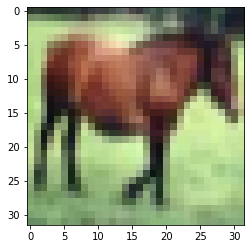

In [31]:
image = train_images[7]

# 좌우반전
hflipped = tf.image.flip_left_right(image)
plt.imshow(hflipped)

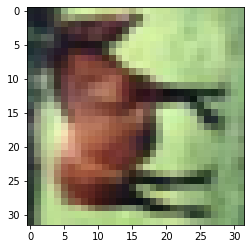

In [32]:
# 가로 * 세로 사이즈 교환
transposed = tf.image.transpose(image)
plt.imshow(transposed)

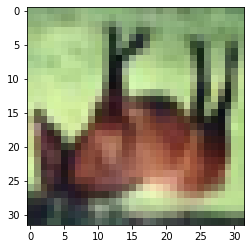

In [33]:
# 상하반전
vflipped = tf.image.flip_up_down(image)
plt.imshow(vflipped)

In [34]:
pip install keras-cv 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394 kB 34.4 MB/s 


In [35]:
# cifar10에서 샘플 10개를 사용함
train_10 = train_images[0:10].reshape((10, 32, 32, 3))

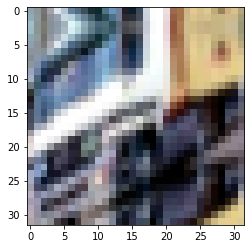

In [36]:
import keras_cv
from keras import layers
from tensorflow.keras.utils import array_to_img #Numpy배열로 변환 

aug = keras_cv.layers.RandAugment(value_range=(0, 255))(train_10)
plt.imshow(array_to_img(aug[1]))

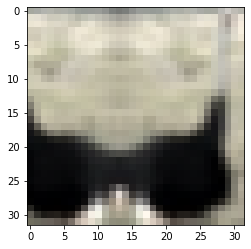

In [37]:
a = keras_cv.layers.RandAugment(value_range=(0, 255))(train_images[121])  
plt.imshow(array_to_img(a))

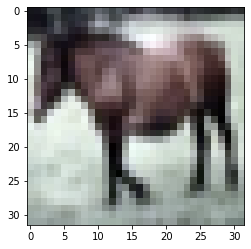

In [38]:
a = keras_cv.layers.RandAugment(value_range=(0, 255))(train_images[7])  
plt.imshow(array_to_img(a))

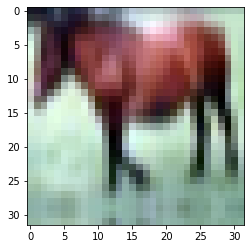

In [39]:
a = keras_cv.layers.RandAugment(value_range=(0, 255))(train_images[7])  
plt.imshow(array_to_img(a))

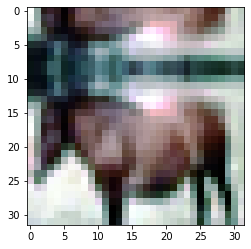

In [40]:
a = keras_cv.layers.RandAugment(value_range=(0, 255))(train_images[7])  
plt.imshow(array_to_img(a))

#### **2.컨브넷에 추가할 데이터 증식 단계 정의하기**


*   RandomFlip("horizontal") : 랜덤하게 50% 이미지를 수평으로 뒤집기
*   RandomRotation(0.1) : [-10%, +10%] 범위 안에서 랜덤한 값만큼 회전, 각도로 표현하면 [-36, +36] 범위를 갖음
*   RandomZoom(0.2) :  [-20%, +20%] 범위 안에서 랜덤한 값만큼 확대/축소
 

In [42]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),      #[-10%, +10%] 범위 안에서 랜덤한 값만큼 회전 
        layers.RandomZoom(0.2),          #[-20%, +20%] 범위 안에서 랜덤한 값만큼 확대/축소
    ]
)

#### **3.랜덤하게 증식된 훈련 이미지 출력하기**

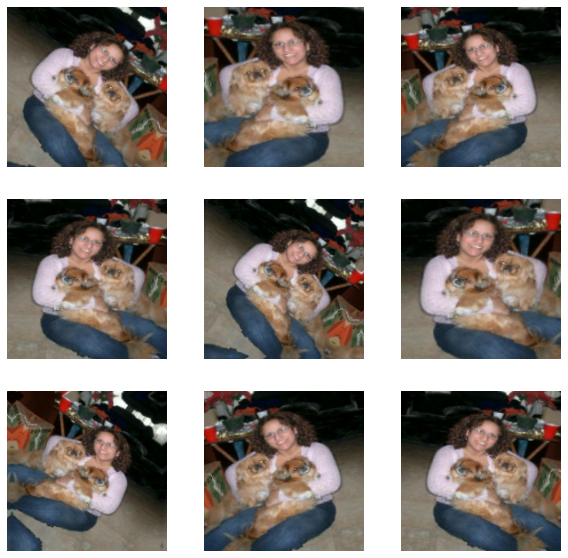

In [43]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#### 4.이미지 증식과 드롭아웃을 포함한 컨브넷 만들기

*   Drop-out 
     - 개념 : 서로 연결된 연결망(layer)에서 0부터 1사이의 확률로 뉴런을 제거 하는 기법
    
    - 사용목적 : 어떤 특정한 설명변수 Feature만을 과도하게 집중하여 학습함으로써 발생할 수 있는 과대적합(Overfitting)을 방지하기 위해 사용



In [44]:
inputs = keras.Input(shape=(180, 180, 3))

# 데이터 증식
x = data_augmentation(inputs) 

# 데이터 정규화
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

# 드롭아웃 
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)

# 모델설정
model1.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")